### Introduction to Autoencoders and Variational Autoencoders (VAEs)

In this tutorial, we will explore the concepts of **Autoencoders (AEs)** and **Variational Autoencoders (VAEs)**, focusing on how they learn latent space representations and reconstruct data. The tutorial is structured to compare the behavior of these models, particularly:

1. **Latent Space Visualization**:
   - We will examine how data is represented in a lower-dimensional latent space.
   - Autoencoders learn latent representations through simple reconstruction, while VAEs impose a probabilistic structure on the latent space.

2. **Reconstruction Quality**:
   - We will observe how the models reconstruct input data from their latent representations.
   - This allows us to understand the impact of the regularization applied in VAEs.

3. **Loss Function Analysis**:
   - Autoencoders minimize the reconstruction loss (e.g., Mean Squared Error, MSE), directly encouraging accurate reconstructions.
   - VAEs use a combination of:
     - **Reconstruction Loss**: Measures the quality of reconstructed data.
     - **KL Divergence**: Regularizes the latent space to match a prior distribution (e.g., a standard Gaussian).

In [1]:
# Important libraries
import torch
import warnings
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt;
from sympy.solvers.diophantine.diophantine import reconstruct
from torch.nn import MSELoss

plt.rcParams['figure.dpi'] = 100

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


In [3]:
# Load MNIST dataset, has 60,000 images of hand annotated digits
data_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               transform=torchvision.transforms.ToTensor(),
                               train=True,
                               download=True),
    batch_size=128,
    shuffle=True
)
data_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               transform=torchvision.transforms.ToTensor(),
                               train=False,
                               download=True),
    batch_size=128,
    shuffle=True
)

In [4]:
# Look at datas shape, should be (batch_size, 1, x pix, y pix)
x, y = next(iter(data_train))
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

# Autoencoder

In [5]:
# Encoder: Compress input to latent space
# Architecture: 784 -> 512 -> latent_dims
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dims),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)  # Output latent representation

In [6]:
# Test the encoder with a single batch, should output (batch_size, latent_dims)
encoder = Encoder(2)
z = encoder(x)
z.shape

torch.Size([128, 2])

In [7]:
# Decoder: Reconstruct input from latent space
# Architecture: latent_dims -> 512 -> 784
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU())

    def forward(self, z):
        return self.decoder(z).reshape((-1, 1, 28, 28))  # Reshape back to (batch_size, 1, 28, 28)

In [8]:
# Test the decoder with a single batch, should output (batch_size, 1, 28, 28)
decoder = Decoder(2)
x_hat = decoder(z)
x_hat.shape

torch.Size([128, 1, 28, 28])

In [9]:
# Autoencoder: Combine Encoder and Decoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)  # Return reconstructed image

In [10]:
# Test the autoencoder with a single batch, should output (batch_size, 1, 28, 28)
autoencoder = Autoencoder(2)
x_hat = autoencoder(x)
x_hat.shape

torch.Size([128, 1, 28, 28])

In [11]:
# Training loop
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        epoch_loss = 0
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()

            reconstructed = autoencoder(x)
            loss = criterion(x, reconstructed)
            loss.backward()

            opt.step()
            epoch_loss += loss.item()
        print(f'Epoch: {epoch + 1}, Loss={epoch_loss}')

In [12]:
autoencoder = Autoencoder(3).to(device)
train(autoencoder, data_train)

Epoch: 1, Loss=30.629031032323837
Epoch: 2, Loss=25.7397754304111
Epoch: 3, Loss=24.347790583968163
Epoch: 4, Loss=23.24657204002142
Epoch: 5, Loss=22.75942650437355
Epoch: 6, Loss=22.449606087058783
Epoch: 7, Loss=22.154324911534786
Epoch: 8, Loss=21.882900051772594
Epoch: 9, Loss=21.64725909009576
Epoch: 10, Loss=21.394587703049183
Epoch: 11, Loss=21.119760554283857
Epoch: 12, Loss=20.960078425705433
Epoch: 13, Loss=20.83778465911746
Epoch: 14, Loss=20.697953637689352
Epoch: 15, Loss=20.489936351776123
Epoch: 16, Loss=20.367503982037306
Epoch: 17, Loss=20.165807262063026
Epoch: 18, Loss=20.077973317354918
Epoch: 19, Loss=20.02655516564846
Epoch: 20, Loss=19.970719911158085


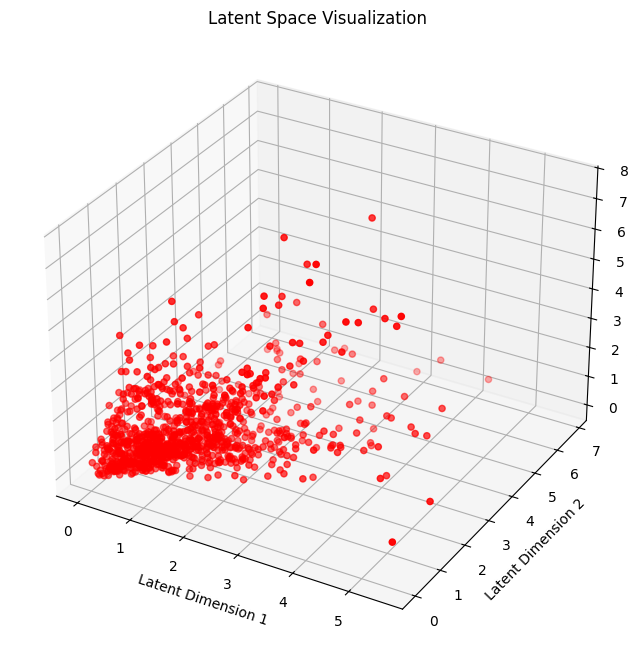

In [13]:
def plot_latent_space(latents, title='Latent Space Visualization'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(latents[:, 0], latents[:, 1], latents[:, 2], c='r', marker='o')
    ax.set_title(title)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Latent Dimension 3')
    plt.show()


def extract_latent_space(encoder, data, device, num_samples=1000):
    latents = []
    for i in range(num_samples):
        img = data[i][0].unsqueeze(0).to(device)  # Get a single sample
        latent = encoder(img)  # Pass through encoder
        latents.append(latent.detach().cpu().numpy())
    return np.vstack(latents)


latents = extract_latent_space(autoencoder.encoder, data_test.dataset, device, num_samples=1000)
plot_latent_space(latents)

In [14]:
# Reconstructed image grid visualization
reconstructed = autoencoder.decoder(torch.Tensor(latents).to(device))
print(reconstructed.shape)
recon_img = reconstructed.permute(0, 2, 3, 1).detach().cpu().numpy()
recon_img.shape

torch.Size([1000, 1, 28, 28])


(1000, 28, 28, 1)

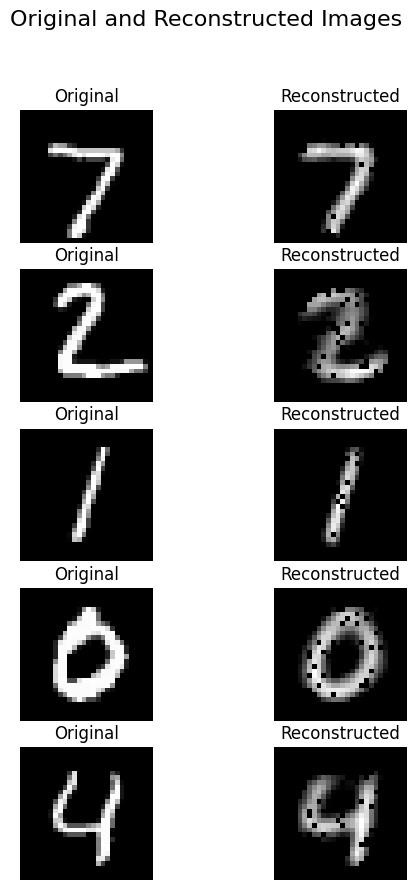

In [15]:
import matplotlib.pyplot as plt


def plot_reconstructions(original_images, reconstructed_images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(6, 2 * num_images))
    fig.suptitle('Original and Reconstructed Images', fontsize=16)

    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(original_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Plot reconstructed image
        axes[i, 1].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Reconstructed')
        axes[i, 1].axis('off')


original_images = [data_test.dataset[i][0] for i in range(5)]
reconstructed_images = [recon_img[i] for i in range(5)]
plot_reconstructions(original_images, reconstructed_images, num_images=5)

# VAE

In [16]:
# Variational Encoder with reparameterization trick
# Refer to the lecture slides, the forward pass should have an attribute that allows for the KL divergence to be calculated since it only depends on the encoder network
# We need to include the reparameterization trick in the forward pass, this means self.normal somewhere
# Architecture: 784 -> 512 -> latent_dims, one output for mean and one output for log-variance
# Remeber variance has to be posative

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc_mu = nn.Linear(512, latent_dims)
        self.fc_logvar = nn.Linear(512, latent_dims)
        self.N = torch.distributions.Normal(0, 1)  # Normal distribution for reparameterization trick

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten input

        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        sigma = torch.exp(0.5 * logvar)  # Variance must be positive
        eps = self.N.sample(mu.shape).to(mu.device)  # Assume we set 'device' as the device we are running the model on

        # Reparameterization, sample from N(0, 1) and scale by sigma, then shift by mu to get z
        z = mu + sigma * self.N.sample(mu.shape).to(device)
        self.kl = 0.5 * (sigma ** 2 + mu ** 2 - 1 - logvar).sum()  # KL divergence
        return z

In [17]:
# Test the VariationalEncoder with a single batch, should output (batch_size, latent_dims) representing th
encoder = VariationalEncoder(2).to(device)
z = encoder(x.to(device))
z.shape

torch.Size([128, 2])

In [18]:
# Variational Autoencoder (VAE), reuse the Decoder class from the previous example 
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [19]:
# Test the VAE with a single batch, should output (batch_size, 1, 28, 28)
vae = VariationalAutoencoder(2).to(device)
x_hat = vae(x.to(device))
x_hat.shape

torch.Size([128, 1, 28, 28])

In [20]:
# Create a training loop for the VAE
def train_vae(vae, data, epochs=20):
    criterion = MSELoss()
    opt = torch.optim.Adam(vae.parameters())
    for epoch in range(epochs):
        epoch_loss = 0
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            # Include the reconstruction loss (MSE) + KL divergence
            loss = criterion(x_hat, x) + vae.encoder.kl
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        print(f'Epoch: {epoch + 1}, Loss={epoch_loss}')

**Train both the Autoencoder and VAE and visualize the latent space and reconstructed images**

In [21]:
# Latent space visualization (run function as is to visualize latent space)
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        # Sample latent space representation
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', alpha=0.5, s=1)
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

In [22]:
# Reconstructed image grid visualization (Run function as is to visualize reconstructed images)
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):  # Default range and grid size
    w = 28  # Image width
    img = np.zeros((n * w, n * w))  # Blank image
    for i, y in enumerate(np.linspace(*r1, n)):  # Iterate over latent space
        for j, x in enumerate(np.linspace(*r0, n)):  # Iterate over latent space
            z = torch.Tensor([[x, y]]).to(device)  # Single latent space representation
            x_hat = autoencoder.decoder(z)  # Reconstruct image
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()  # Reshape and move to CPU
            img[(n - 1 - i) * w:(n - 1 - i + 1) * w, j * w:(j + 1) * w] = x_hat  # Add image to grid
    plt.axis('off')
    plt.imshow(img, extent=[*r0, *r1], cmap='binary')
    plt.show()

Epoch: 1, Loss=30.453913427889347
Epoch: 2, Loss=28.325099423527718
Epoch: 3, Loss=27.70045606419444
Epoch: 4, Loss=27.296963047236204
Epoch: 5, Loss=26.86200799793005
Epoch: 6, Loss=26.322502978146076
Epoch: 7, Loss=26.016672872006893
Epoch: 8, Loss=25.746493991464376
Epoch: 9, Loss=25.39690664410591
Epoch: 10, Loss=25.03707357123494
Epoch: 11, Loss=24.61728723347187
Epoch: 12, Loss=24.3702840693295
Epoch: 13, Loss=24.27493592724204
Epoch: 14, Loss=24.175718154758215
Epoch: 15, Loss=23.731759283691645
Epoch: 16, Loss=23.635013431310654
Epoch: 17, Loss=23.548119869083166
Epoch: 18, Loss=23.508774790912867
Epoch: 19, Loss=23.437753401696682
Epoch: 20, Loss=23.271249640733004


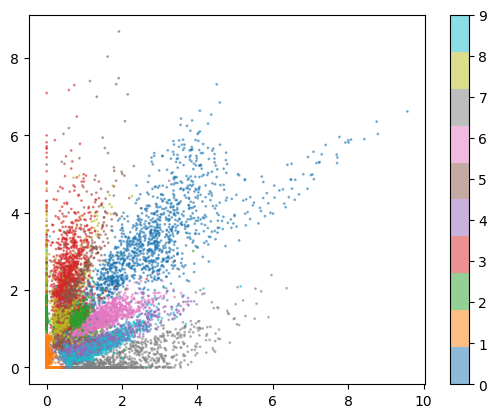

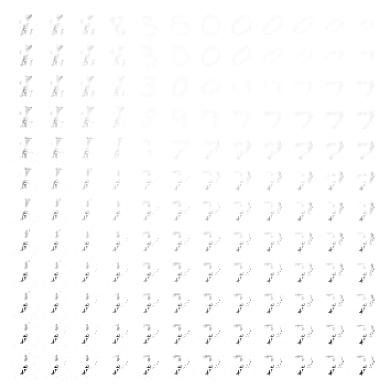

In [23]:
# Autoencoder example
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)
train(autoencoder, data_train)
plot_latent(autoencoder, data_train)
plot_reconstructed(autoencoder)

Epoch: 1, Loss=84.60595063120127
Epoch: 2, Loss=34.952460035681725
Epoch: 3, Loss=34.266855359077454
Epoch: 4, Loss=34.01133434474468
Epoch: 5, Loss=33.87027560174465
Epoch: 6, Loss=33.79542355239391
Epoch: 7, Loss=33.6885109692812
Epoch: 8, Loss=33.546243883669376
Epoch: 9, Loss=33.51469702273607
Epoch: 10, Loss=33.50140497088432
Epoch: 11, Loss=33.330163314938545
Epoch: 12, Loss=33.15082924067974
Epoch: 13, Loss=33.13349054008722
Epoch: 14, Loss=33.119978711009026
Epoch: 15, Loss=33.11093430221081
Epoch: 16, Loss=33.104401387274265
Epoch: 17, Loss=33.072536781430244
Epoch: 18, Loss=32.96664108335972
Epoch: 19, Loss=32.942367888987064
Epoch: 20, Loss=32.934038773179054


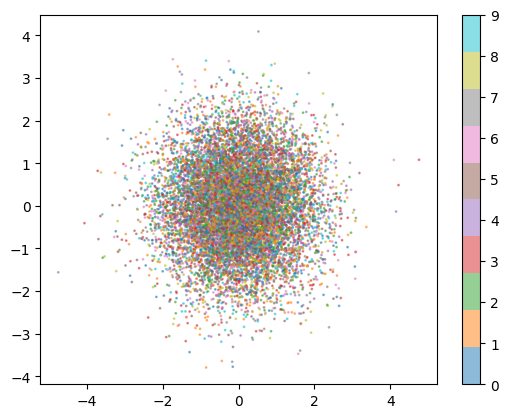

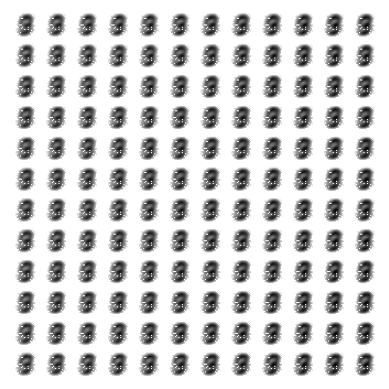

In [24]:
# VAE example
vae = VariationalAutoencoder(latent_dims).to(device)
train_vae(vae, data_train)
plot_latent(vae, data_train)
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

**Modify the VAE training loop and consider the case of no MSE loss and only KL divergence.**   
**Plot the latent space and reconstructed images for both cases.**

In [25]:
# 1) Only KL divergence
def train_vae(vae, data, epochs=20, kl_weight=1):
    opt = torch.optim.Adam(vae.parameters())
    for epoch in range(epochs):
        epoch_loss = 0
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            # Only KL divergence
            loss = vae.encoder.kl
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        print(f'Epoch: {epoch + 1}, Loss={epoch_loss}')

Epoch: 1, Loss=40.31800196086988
Epoch: 2, Loss=0.7645942261442542
Epoch: 3, Loss=0.27051844692323357
Epoch: 4, Loss=0.11821820656768978
Epoch: 5, Loss=0.057736055518034846
Epoch: 6, Loss=0.031203433347400278
Epoch: 7, Loss=0.017353209637803957
Epoch: 8, Loss=0.009584863670170307
Epoch: 9, Loss=0.005259425481199287
Epoch: 10, Loss=0.002735819885856472
Epoch: 11, Loss=0.0011515717633301392
Epoch: 12, Loss=0.00015227005496853963
Epoch: 13, Loss=-0.0004832540435018018
Epoch: 14, Loss=-0.0009329325821454404
Epoch: 15, Loss=-0.001192057063235552
Epoch: 16, Loss=-0.0014157096361486765
Epoch: 17, Loss=-0.0015369443232771118
Epoch: 18, Loss=-0.0016346757448673088
Epoch: 19, Loss=-0.0016371888746107288
Epoch: 20, Loss=-0.0016620935538185222


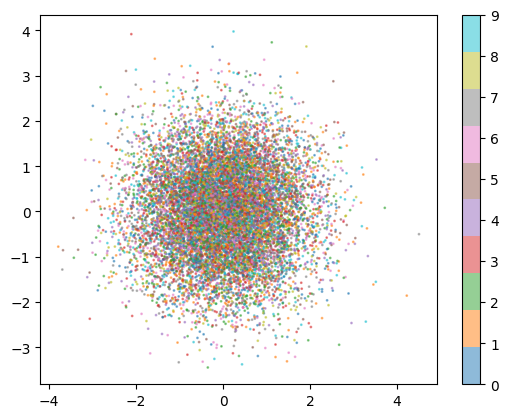

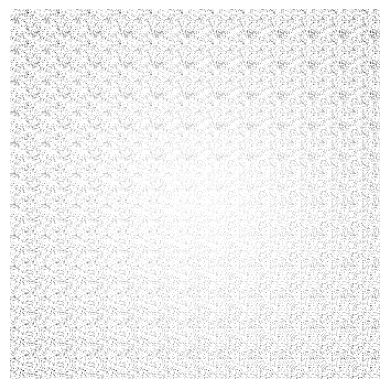

In [26]:
# Plot the latent space and reconstructed images for the VAE with only KL divergence
vae_kl_only = VariationalAutoencoder(2).to(device)
train_vae(vae_kl_only, data_train, kl_weight=1)
plot_latent(vae_kl_only, data_train)
plot_reconstructed(vae_kl_only, r0=(-3, 3), r1=(-3, 3))

In [27]:
# Can you explain your observations?
# When there is only KL-divergence loss, the representation is more uniform.

In [28]:
# 2) Only MSE loss
def train_vae(vae, data, epochs=20, kl_weight=1):
    criterion = MSELoss()
    opt = torch.optim.Adam(vae.parameters())
    for epoch in range(epochs):
        epoch_loss = 0
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            # Only MSE loss
            loss = criterion(x_hat, x)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        print(f'Epoch: {epoch + 1}, Loss={epoch_loss}')

Epoch: 1, Loss=27.24125326424837
Epoch: 2, Loss=25.122621405869722
Epoch: 3, Loss=24.477631855756044
Epoch: 4, Loss=24.11381532624364
Epoch: 5, Loss=23.801941845566034
Epoch: 6, Loss=23.520377200096846
Epoch: 7, Loss=23.223582312464714
Epoch: 8, Loss=22.976360574364662
Epoch: 9, Loss=22.821524553000927
Epoch: 10, Loss=22.690644685178995
Epoch: 11, Loss=22.52221218496561
Epoch: 12, Loss=22.43510079756379
Epoch: 13, Loss=22.320725291967392
Epoch: 14, Loss=22.121543388813734
Epoch: 15, Loss=22.05892999097705
Epoch: 16, Loss=21.967994295060635
Epoch: 17, Loss=21.77635733038187
Epoch: 18, Loss=21.68246229737997
Epoch: 19, Loss=21.609144624322653
Epoch: 20, Loss=21.430994119495153


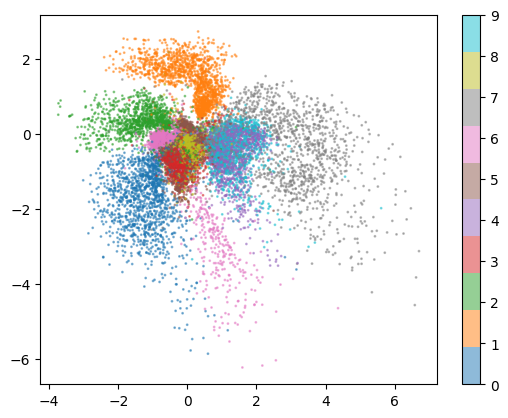

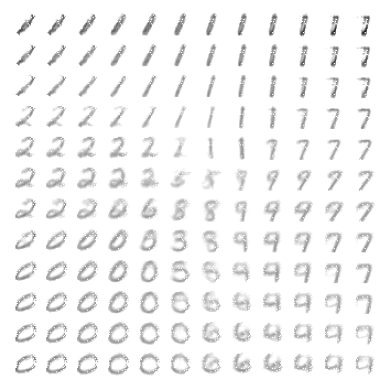

In [29]:
# Plot the latent space and reconstructed images for the VAE with only MSE loss
vae = VariationalAutoencoder(2).to(device)
train_vae(vae, data_train, kl_weight=0)
plot_latent(vae, data_train)
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

In [30]:
# Can you explain your observations?
# With only the MSE loss the data is clearly seperable and one can see the transition of the latent spaces from one class to the others.